In [15]:
# STEP 1 -  의존성 로드 ############################################################
import numpy as np
import pandas as pd
import os
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import seaborn as sns # seaborn ref : https://greeksharifa.github.io/machine_learning/2019/12/05/Seaborn-Module/
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import statsmodels.api as sm;
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt # plotting
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
## 정확도 지표 정의
def metrics(y_test,pred):
    print("ACC : ",accuracy_score(y_test,pred))
    print("Precision : ", precision_score(y_test,pred))
    print("recall(TP rate) : ", recall_score(y_test,pred))
    print("F1 : " , f1_score(y_test,pred))
    print("ROC SCORE : ", roc_auc_score(y_test,pred,average="macro"))


%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

In [16]:
## DATA LOAD
df = pd.read_csv('2018_17_16_OUTCOME.csv')
df.head()
df.isnull()

,age,wt_itvex,ainc,DI1_pr,DI2_pr,HE_DMfh3,HE_ht,HE_wc,HE_BMI,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_hcv,HE_HCT,HE_Uro,HE_NNAL,HE_UCREA,BM7,GS_mea_r_1,N_WAT_C,N_INTK,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_FE,N_B1
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5990,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5991,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5992,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5993,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [17]:
print('DATA IS : \n', pd.Series(df.HE_DM).value_counts())

DATA IS : 
 0    4082
1    1913
Name: HE_DM, dtype: int64


In [18]:
## SETTING DEPENDENT VAR, INDEPENDENT VARS 

Y = df.HE_DM # y축 설정
X = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42) ## test.size 0.2~0.25 설정할거임

0.858254585881045
ACC :  0.858254585881045
Precision :  0.8073770491803278
recall(TP rate) :  0.7099099099099099
F1 :  0.7555129434324065
ROC SCORE :  0.8171736044726398


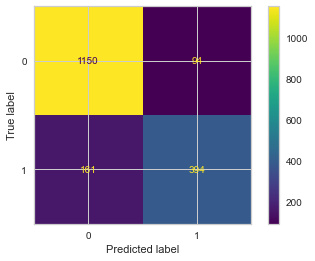

In [19]:
## 16,17,18 Prediction

pipe = Pipeline([('scaler',StandardScaler()), ('classifiers',XGBClassifier())])
pipe.fit(X_train,Y_train)
y_preds=pipe.predict(X_test)
print(pipe.score(X_test,Y_test))
metrics(Y_test,y_preds)
plot_confusion_matrix(pipe,X_test,Y_test)

In [24]:
## DO SMOTE ALG
smote = SMOTE(random_state=0)

X_train_over,Y_train_over = smote.fit_sample(X_train,Y_train)
#X_test_over,Y_test_over = smote.fit_sample(X_test,Y_test)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, Y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, Y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(Y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (4196, 30) (4196,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (5676, 30) (5676,)
SMOTE 적용 후 레이블 값 분포: 
 1    2838
0    2838
Name: HE_DM, dtype: int64


0.8321289605336298
ACC :  0.8321289605336298
Precision :  0.6992125984251969
recall(TP rate) :  0.8
F1 :  0.746218487394958
ROC SCORE :  0.8232315112540194


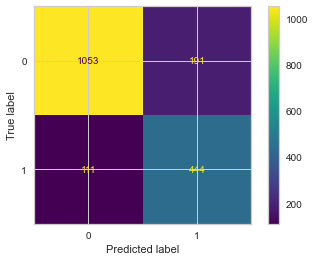

In [25]:
##PIPELINE RESAMPLED WORKFLOW
pipe = Pipeline([('scaler',StandardScaler()), ('classifiers',AdaBoostClassifier())])
pipe.fit(X_train_over,Y_train_over)
#y_preds=pipe.predict(X_test_over)
y_preds=pipe.predict(X_test)
print(pipe.score(X_test,Y_test))
metrics(Y_test,y_preds)
plot_confusion_matrix(pipe,X_test,Y_test)

In [26]:
## K-FOLD VALIDATION 
scores = cross_val_score(estimator=pipe,
                         X=df.drop(columns=["HE_DM"]),
                         y=df.HE_DM,
                         #X=X_test_over,
                         #y=Y_test_over,
                         cv=10,
                         n_jobs=-1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.75833333 0.74       0.72833333 0.86166667 0.91166667 0.91318865
 0.92153589 0.9048414  0.91652755 0.92487479]
CV 정확도: 0.858 +/- 0.078


/Users/hobbes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


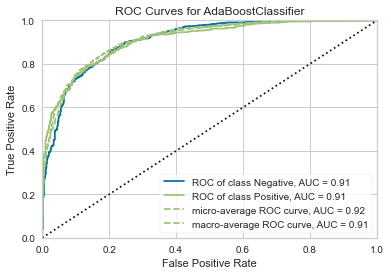

In [27]:
from yellowbrick.classifier import ROCAUC
 
 
visualizer = ROCAUC(pipe, classes=['Negative','Positive'])
visualizer.fit(X_train_over,Y_train_over)
visualizer.score(X_test, Y_test)
visualizer.show()

TypeError: predict_proba() missing 1 required positional argument: 'data'

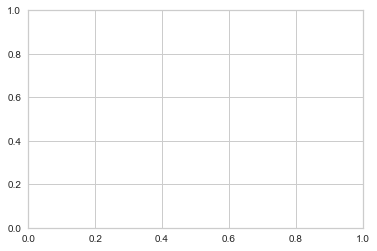

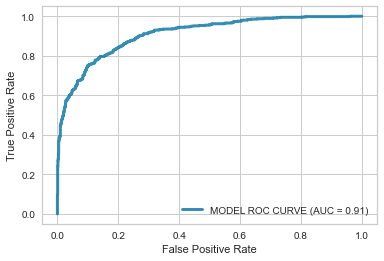

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plot_roc_curve(pipe,X_test,Y_test,alpha=0.8, lw=3,drop_intermediate=True,name="MODEL ROC CURVE")
plot_roc_curve(CatBoostClassifier,X_test,Y_test,alpha=0.8, lw=3,drop_intermediate=True,name=" CURVE")
#plot_roc_curve(pipe,X_test,Y_test,alpha=0.8, lw=1,drop_intermediate=True,name="")

# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)
# plt.show()

In [ ]:
X.shape